In [1]:
#!pip install tensorflow

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.optimizers import Adam
import math
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow import keras
from keras import layers

#Dataset Description

The Oxford Flowers102 dataset is a consistent of 102 flower categories commonly occurring in the United Kingdom. Each class consists of between 40 and 258 images. The images have large scale, pose and light variations. In addition, there are categories that have large variations within the category and several very similar categories.

The dataset is divided into a training set, a validation set and a test set. The training set and validation set each consist of 10 images per class (totalling 1020 images each). The test set consists of the remaining 6149 images (minimum 20 per class).

In [3]:
# data
dataset_name = "oxford_flowers102"
dataset_repetitions = 5
num_epochs = 1  # train for at least 50 epochs for good results
image_size = 64
# # KID = Kernel Inception Distance, see related section
# kid_image_size = 75
# kid_diffusion_steps = 5
# plot_diffusion_steps = 20

# sampling
min_signal_rate = 0.02
max_signal_rate = 0.95

# architecture
embedding_dims = 32
embedding_max_frequency = 1000.0
widths = [32, 64, 96, 128]
block_depth = 2

# optimization
batch_size = 64
ema = 0.999
learning_rate = 1e-3
weight_decay = 1e-4

#Preprocess Image, Prepare Dataset, split in Train and Validation Dataset

In [4]:
def preprocess_image(data):
    # center crop image
    height = tf.shape(data["image"])[0]
    width = tf.shape(data["image"])[1]
    crop_size = tf.minimum(height, width)
    image = tf.image.crop_to_bounding_box(
        data["image"],
        (height - crop_size) // 2,
        (width - crop_size) // 2,
        crop_size,
        crop_size,
    )

    # resize and clip
    # for image downsampling it is important to turn on antialiasing
    image = tf.image.resize(image, size=[image_size, image_size], antialias=True)
    return tf.clip_by_value(image / 255.0, 0.0, 1.0)


def prepare_dataset(split):
    # the validation dataset is shuffled as well, because data order matters
    # for the KID estimation
    return (
        tfds.load(dataset_name, split=split, shuffle_files=True)
        .map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
        .cache()
        .repeat(dataset_repetitions)
        .shuffle(10 * batch_size)
        .batch(batch_size, drop_remainder=True)
        .prefetch(buffer_size=tf.data.AUTOTUNE)
    )

# load dataset
train_dataset = prepare_dataset("train[:80%]+validation[:80%]+test[:80%]")
val_dataset = prepare_dataset("train[80%:]+validation[80%:]+test[80%:]")

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Shuffling /root/tensorflow_datasets/oxford_flowers102/2.1.1.incompleteDT7PBZ/oxford_flowers102-test.tfrecord*.…

Generating validation examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_flowers102/2.1.1.incompleteDT7PBZ/oxford_flowers102-validation.tfre…

Dataset oxford_flowers102 downloaded and prepared to /root/tensorflow_datasets/oxford_flowers102/2.1.1. Subsequent calls will reuse this data.


#Print train and val_dataset

In [5]:
train_dataset

<_PrefetchDataset element_spec=TensorSpec(shape=(64, 64, 64, 3), dtype=tf.float32, name=None)>

In [6]:
val_dataset

<_PrefetchDataset element_spec=TensorSpec(shape=(64, 64, 64, 3), dtype=tf.float32, name=None)>

#Reload data again, convert the datset into numpy format, extract image(X) and label(Y) from train and validation datasets

In [7]:
def preprocess_image(data):
    # center crop image
    height = tf.shape(data["image"])[0]
    width = tf.shape(data["image"])[1]
    crop_size = tf.minimum(height, width)
    image = tf.image.crop_to_bounding_box(
        data["image"],
        (height - crop_size) // 2,
        (width - crop_size) // 2,
        crop_size,
        crop_size,
    )

    # resize and clip
    # for image downsampling, it is important to turn on antialiasing
    image = tf.image.resize(image, size=[image_size, image_size], antialias=True)
    return {"image": tf.clip_by_value(image / 255.0, 0.0, 1.0), "label": data["label"]}


def prepare_dataset(split):
    # the validation dataset is shuffled as well, because data order matters
    # for the KID estimation
    return (
        tfds.load(dataset_name, split=split, shuffle_files=True)
        .map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
        .cache()
        .repeat(dataset_repetitions)
        .shuffle(10 * batch_size)
        .batch(batch_size, drop_remainder=True)
        .prefetch(buffer_size=tf.data.AUTOTUNE)
    )


# load dataset
train_dataset = prepare_dataset("train[:80%]+validation[:80%]+test[:80%]")
val_dataset = prepare_dataset("train[80%:]+validation[80%:]+test[80%:]")

# Convert the datasets to NumPy format
train_data_np = tfds.as_numpy(train_dataset)
val_data_np = tfds.as_numpy(val_dataset)

# Extract images (X) and labels (Y) from train and validation datasets
X_train = []
Y_train = []
X_test = []
Y_test = []

for batch in train_data_np:
    images = batch['image']
    labels = batch['label']
    X_train.extend(images)
    Y_train.extend(labels)

for batch in val_data_np:
    images = batch['image']
    labels = batch['label']
    X_test.extend(images)
    Y_test.extend(labels)

In [8]:
#X_train

# Flatten Image

In [9]:
# Y_train = Y_train.flatten()
# Y_test = Y_test.flatten()

#Plot First few images

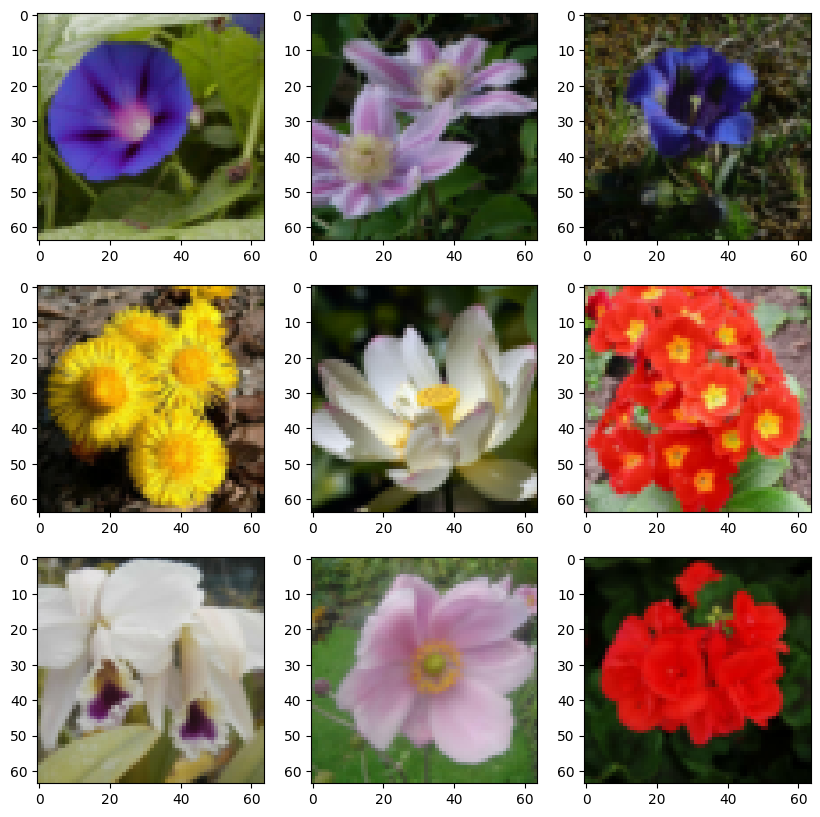

In [10]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(10,10))

for i in range(9):
    # define subplot
    plt.subplot(3, 3, i+1)
    # plot raw pixel data
    plt.imshow(X_train[i])

# show the figure
plt.show()


#Visualize data by Plotting images

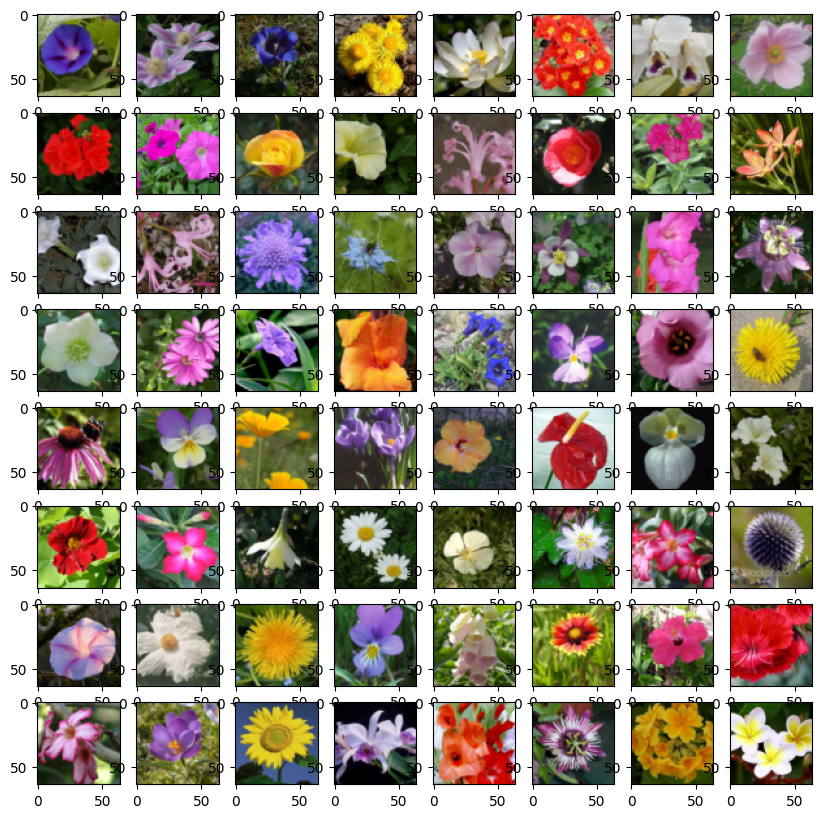

In [11]:
# visualize data by plotting images
fig, ax = plt.subplots(8, 8, figsize=(10,10))
k = 0
 
for i in range(8):
    for j in range(8):
        ax[i][j].imshow(X_train[k], aspect='auto')
        k += 1
 
plt.show()

# Implement DenseNet Model

In [12]:
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model


#Create DenseNet Model

In [13]:
def create_dense_net(input_shape, num_classes):
    input_layer = Input(shape=input_shape)
    base_model = DenseNet121(input_tensor=input_layer, include_top=False, weights=None)

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    output_layer = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=input_layer, outputs=output_layer)
    return model


# Compile the model

In [14]:
input_shape = (image_size, image_size, 3)
num_classes = len(np.unique(Y_train))

model = create_dense_net(input_shape, num_classes)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate, weight_decay=weight_decay),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [15]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 70, 70, 3)   0           ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 32, 32, 64)   9408        ['zero_padding2d[0][0]']         
                                                                                                  
 conv1/bn (BatchNormalization)  (None, 32, 32, 64)   256         ['conv1/conv[0][0]']             
                                                                                              

In [16]:
import numpy as np

X_train = np.array(X_train)
Y_train = np.array(Y_train)
X_test = np.array(X_test)
Y_test = np.array(Y_test)


#Train The Model

In [21]:
hist = model.fit(X_train, Y_train, epochs = 30, batch_size = batch_size, validation_data=(X_test, Y_test))
#callbacks = [tf.keras.callbacks.EarlyStopping(patience = 5)]

Epoch 1/30
511/511 [==============================] - 52s 102ms/step - loss: 0.0396 - accuracy: 0.9891 - val_loss: 1.2801 - val_accuracy: 0.7336
Epoch 2/30
511/511 [==============================] - 51s 100ms/step - loss: 0.0090 - accuracy: 0.9982 - val_loss: 1.7032 - val_accuracy: 0.6565
Epoch 3/30
511/511 [==============================] - 51s 100ms/step - loss: 0.0500 - accuracy: 0.9856 - val_loss: 2.5868 - val_accuracy: 0.5727
Epoch 4/30
511/511 [==============================] - 51s 100ms/step - loss: 0.0357 - accuracy: 0.9893 - val_loss: 1.6088 - val_accuracy: 0.6975
Epoch 5/30
511/511 [==============================] - 51s 100ms/step - loss: 0.0041 - accuracy: 0.9991 - val_loss: 1.7268 - val_accuracy: 0.6890
Epoch 6/30
511/511 [==============================] - 52s 101ms/step - loss: 0.0597 - accuracy: 0.9815 - val_loss: 1.7796 - val_accuracy: 0.6844
Epoch 7/30
511/511 [==============================] - 51s 100ms/step - loss: 0.0018 - accuracy: 0.9998 - val_loss: 1.3550 - val_ac

#Plot loss function

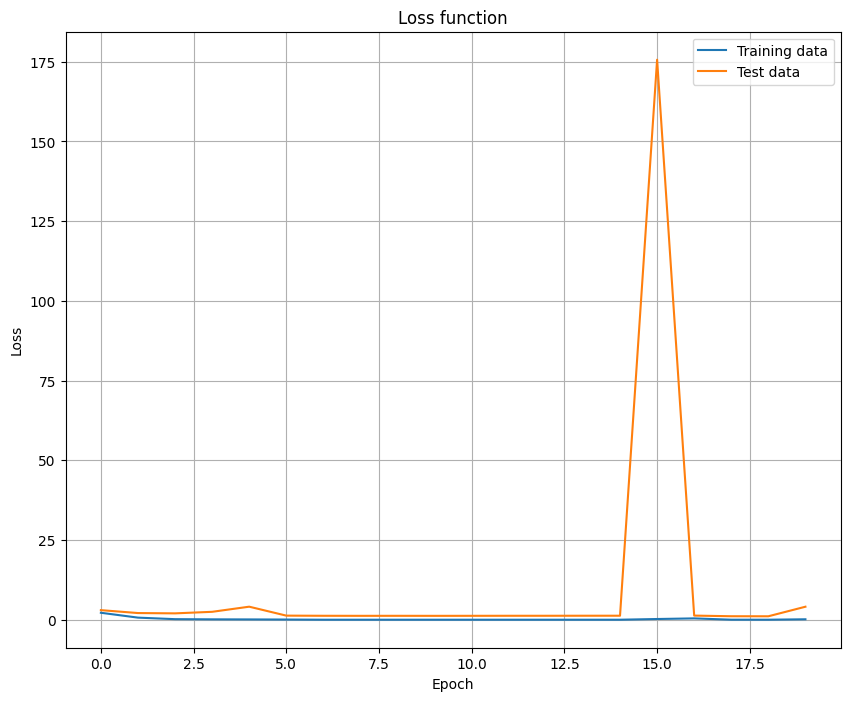

In [18]:
fig = plt.figure(figsize=(10,8))
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Loss function')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.grid()
plt.legend(['Training data', 'Test data'])
plt.show()

# Plot Model Accuracy

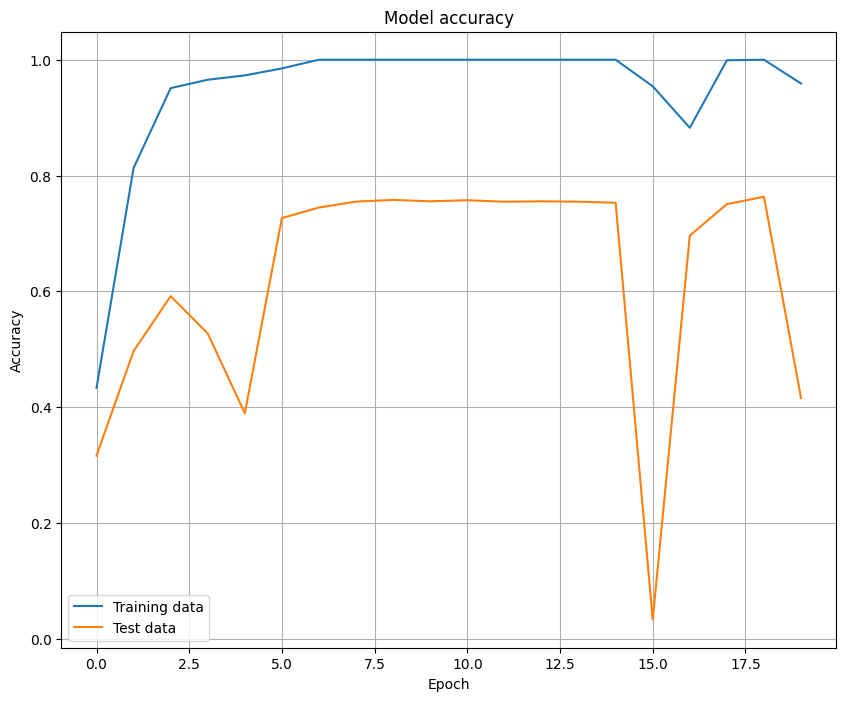

In [19]:
fig = plt.figure(figsize=(10,8))
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.grid()
plt.legend(['Training data', 'Test data'])

#Print Test Accuracy

In [22]:
loss, accuracy = model.evaluate(X_test, Y_test, batch_size=batch_size)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)


127/127 [==============================] - 3s 23ms/step - loss: 1.2862 - accuracy: 0.7573
Test Loss: 1.2862107753753662
Test Accuracy: 0.7572588324546814
